In [ ]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install transformers datasets pandas scikit-learn numpy torch seaborn matplotlib streamlit==1.33.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install seacrowd

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset
import os
import re
import random
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

# Cek ketersediaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# 2. Load Dataset
'''
Menggunakan dataset "SEACrowd/indonesian_news_dataset" dari Hugging Face
Dataset ini berisi artikel berita bahasa Indonesia dengan 5 kategori: bola, news, bisnis, tekno, dan otomotif
'''
print("Loading dataset...")
dataset = load_dataset("SEACrowd/indonesian_news_dataset", trust_remote_code=True)
print("Dataset loaded!")

Loading dataset...
Dataset loaded!



Example from training set:
{'index': '0', 'news': 'Liputan6.com, London - Lee Dixon khawatir Arsenal tak bisa merekrut Denis Suarez secara permanen musim panas nanti. Pasalnya sejauh ini, Suarez hanya menjadi cadangan bagi The Gunners.\n\nSuarez dipinjam Arsenal dari Barcelona, Januari lalu. The Gunners juga bisa membelinya pada akhir musim nanti jika permainannya memuaskan.\n\nNamun sejauh ini Suarez tak menjadi pilihan utama di Arsenal. Manajer Unai Emery baru memberinya kesempatan bermain selama 85 menit.\n\n"Emery mungkin tahu kualitas Suarez. Dia tahu Suarez pemain yang dibutuhkannya," kata Dixon seperti dilansir Evening Standard.\n\n"Namun dari sudut pandang Suarez, dia pasti berpikir untuk apa pindah kalau tidak bermain. Jadi mungkin saja dia akan menolak Arsenal," katanya menambahkan.', 'label': 'bola'}

Dataset schema:
{'index': Value(dtype='string', id=None), 'news': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}

Number of training examples: 6127
N

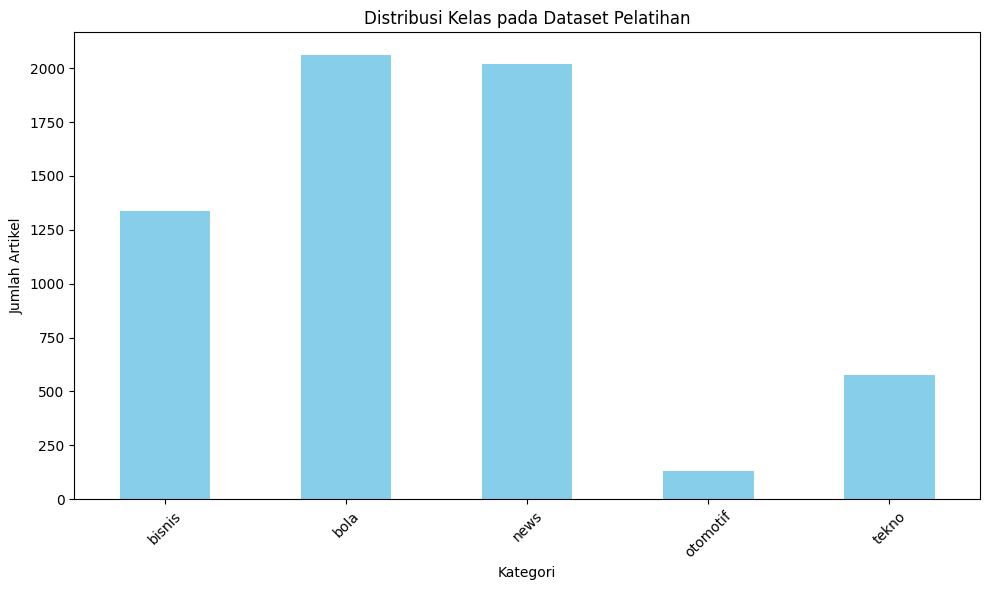

In [15]:
# 3. Explorasi Data
'''
Melihat struktur dataset dan distribusi kelas
'''

# Melihat contoh data
print("\nExample from training set:")
print(dataset['train'][0])

# Melihat skema dataset
print("\nDataset schema:")
print(dataset['train'].features)

# Menghitung jumlah sampel per split
print(f"\nNumber of training examples: {len(dataset['train'])}")
print(f"Number of testing examples: {len(dataset['test'])}")

# Distribusi label dalam dataset
train_labels = [item['label'] for item in dataset['train']]
test_labels = [item['label'] for item in dataset['test']]

print("\nTraining set class distribution:")
train_dist = pd.Series(train_labels).value_counts().sort_index()
print(train_dist)

print("\nTest set class distribution:")
test_dist = pd.Series(test_labels).value_counts().sort_index()
print(test_dist)

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 6))
train_dist.plot(kind='bar', color='skyblue')
plt.title('Distribusi Kelas pada Dataset Pelatihan')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Artikel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# 4. Preprocessing Data
'''
Melakukan preprocessing pada data:
1. Tokenisasi teks menggunakan tokenizer IndoBERT
2. Encoding label kategori menggunakan LabelEncoder
'''

# Load tokenizer for IndoBERT
print("Loading IndoBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Function untuk preprocessing teks
def preprocess_text(text):
    # Hapus karakter non-alfanumerik (kecuali spasi)
    text = re.sub(r'[^\w\s]', '', text)
    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Lowercase
    text = text.lower().strip()
    return text

# Function untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Preprocessing dan tokenisasi data training
print("Preprocessing and tokenizing training data...")
train_texts = [preprocess_text(item['news']) for item in dataset['train']]
train_encodings = tokenize_text(train_texts)

# Preprocessing dan tokenisasi data testing
print("Preprocessing and tokenizing test data...")
test_texts = [preprocess_text(item['news']) for item in dataset['test']]
test_encodings = tokenize_text(test_texts)

# Encoding label menggunakan LabelEncoder
print("Encoding labels...")
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform([item['label'] for item in dataset['train']])
test_labels = label_encoder.transform([item['label'] for item in dataset['test']])

# Menyimpan pemetaan label untuk referensi
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nLabel mapping:")
print(label_mapping)

# Membuat TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    torch.tensor(train_labels, dtype=torch.long)
)
test_dataset = TensorDataset(
    test_encodings['input_ids'], 
    test_encodings['attention_mask'], 
    torch.tensor(test_labels, dtype=torch.long)
)

Loading IndoBERT tokenizer...
Preprocessing and tokenizing training data...
Preprocessing and tokenizing test data...
Encoding labels...

Label mapping:
{0: 'bisnis', 1: 'bola', 2: 'news', 3: 'otomotif', 4: 'tekno'}


In [17]:
# 5. Inisialisasi Model
'''
Menggunakan model IndoBERT dari IndoBenchmark
'''
print("Loading IndoBERT model...")
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels=num_labels
)
model.to(device)
print("Model loaded and moved to", device)

Loading IndoBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cpu


In [19]:
# 6. Konfigurasi Pelatihan
'''
Mengatur hyperparameter untuk fine-tuning model
'''
# Hyperparameters
batch_size = 16
epochs = 3
learning_rate = 2e-5

# Menghitung bobot kelas untuk mengatasi ketidakseimbangan data
class_weights = torch.tensor(
    [1.0 / (train_dist[label_mapping[i]] / len(train_labels)) for i in range(num_labels)],
    dtype=torch.float
).to(device)
print("\nClass weights to handle imbalance:")
for i, weight in enumerate(class_weights):
    print(f"{label_mapping[i]}: {weight.item():.4f}")

# DataLoader
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=batch_size
)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(
    test_dataset,
    sampler=test_sampler,
    batch_size=batch_size
)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

# Jumlah langkah training total
total_steps = len(train_dataloader) * epochs

# Scheduler untuk learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)



Class weights to handle imbalance:
bisnis: 4.5758
bola: 2.9699
news: 3.0377
otomotif: 47.1308
tekno: 10.6003


In [38]:
# 7. Fungsi Pelatihan dan Evaluasi
'''
Fungsi untuk melatih model dan mengevaluasi performa
'''
# Function untuk format waktu
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function untuk menghitung akurasi batch
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function untuk melatih model
def train_model():
    print("Starting training...\n")
    
    # Tracking best accuracy
    best_accuracy = 0
    # For storing evaluation metrics
    eval_metrics = {'accuracy': [], 'f1': []}
    # Store the best F1 score
    best_f1 = 0
    
    # Untuk setiap epoch
    for epoch_i in range(0, epochs):
        print(f"{'=' * 20} Epoch {epoch_i + 1} / {epochs} {'=' * 20}")
        
        # Measure training time per epoch
        t0 = time.time()
        
        # Reset total loss
        total_train_loss = 0
        
        # Training mode
        model.train()
        
        # Untuk setiap batch
        for step, batch in enumerate(train_dataloader):
            # Progress update
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print(f"  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}")
            
            # Unpack batch dan pindahkan ke device
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Reset gradients
            model.zero_grad()
            
            # Forward pass
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_attention_mask,
                labels=b_labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        
        # Calculate average loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Training time
        training_time = format_time(time.time() - t0)
        
        print(f"\n  Average training loss: {avg_train_loss:.2f}")
        print(f"  Training epoch took: {training_time}")
        
        # Evaluation
        print("\n  Running Validation...")
        
        t0 = time.time()
        model.eval()
        
        # Variables for evaluation metrics
        total_eval_accuracy = 0
        total_eval_loss = 0
        all_predictions = []
        all_true_labels = []
        
        # No gradients for validation
        with torch.no_grad():
            for batch in test_dataloader:
                # Unpack batch dan pindahkan ke device
                b_input_ids = batch[0].to(device)
                b_attention_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Forward pass
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_attention_mask,
                    labels=b_labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
                total_eval_loss += loss.item()
                
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                
                # Calculate batch accuracy
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                
                # Store predictions and true labels
                predictions = np.argmax(logits, axis=1)
                all_predictions.extend(predictions)
                all_true_labels.extend(label_ids)
        
        # Report final accuracy
        avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
        avg_val_loss = total_eval_loss / len(test_dataloader)
        
        # Calculate F1 score
        f1 = f1_score(all_true_labels, all_predictions, average='weighted')
        
        # Store metrics
        eval_metrics['accuracy'].append(avg_val_accuracy)
        eval_metrics['f1'].append(f1)
        
        # Save best F1 score
        if f1 > best_f1:
            best_f1 = f1
        
        # Save model if better
        if avg_val_accuracy > best_accuracy:
            print(f"  Improved accuracy from {best_accuracy:.4f} to {avg_val_accuracy:.4f}. Saving model...")
            best_accuracy = avg_val_accuracy
            
            # Save model
            output_dir = './model_save/'
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            model_to_save = model.module if hasattr(model, 'module') else model
            model_to_save.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
        
        # Validation time
        validation_time = format_time(time.time() - t0)
        
        print(f"  Validation Loss: {avg_val_loss:.2f}")
        print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")
        print(f"  Validation F1 Score: {f1:.4f}")
        print(f"  Validation took: {validation_time}")
        
        # Create detailed classification report for last epoch
        if epoch_i == epochs - 1:
            print("\nClassification Report:")
            print(classification_report(
                all_true_labels, 
                all_predictions, 
                target_names=list(label_mapping.values())
            ))
            
            # Create confusion matrix
            cm = confusion_matrix(all_true_labels, all_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=list(label_mapping.values()),
                yticklabels=list(label_mapping.values())
            )
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Visualize training metrics
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(range(1, epochs + 1), eval_metrics['accuracy'], marker='o')
            plt.title('Validation Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(range(1, epochs + 1), eval_metrics['f1'], marker='o', color='orange')
            plt.title('Validation F1 Score per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
    
    print("\nTraining complete!")
    return best_accuracy, best_f1

Starting training...

==================== Epoch 1 / 3 ====================
  Batch    40  of    383.    Elapsed: 0:03:25
  Batch    80  of    383.    Elapsed: 0:06:43
  Batch   120  of    383.    Elapsed: 0:10:03
  Batch   160  of    383.    Elapsed: 0:13:23
  Batch   200  of    383.    Elapsed: 0:16:42
  Batch   240  of    383.    Elapsed: 0:20:02
  Batch   280  of    383.    Elapsed: 0:23:20
  Batch   320  of    383.    Elapsed: 0:26:39
  Batch   360  of    383.    Elapsed: 0:29:57

  Average training loss: 0.07
  Training epoch took: 0:31:51

  Running Validation...
  Improved accuracy from 0.0000 to 0.9457. Saving model...
  Validation Loss: 0.20
  Validation Accuracy: 0.9457
  Validation F1 Score: 0.9472
  Validation took: 0:02:58
==================== Epoch 2 / 3 ====================
  Batch    40  of    383.    Elapsed: 0:03:19
  Batch    80  of    383.    Elapsed: 0:06:36
  Batch   120  of    383.    Elapsed: 0:09:54
  Batch   160  of    383.    Elapsed: 0:13:13
  Batch   200  

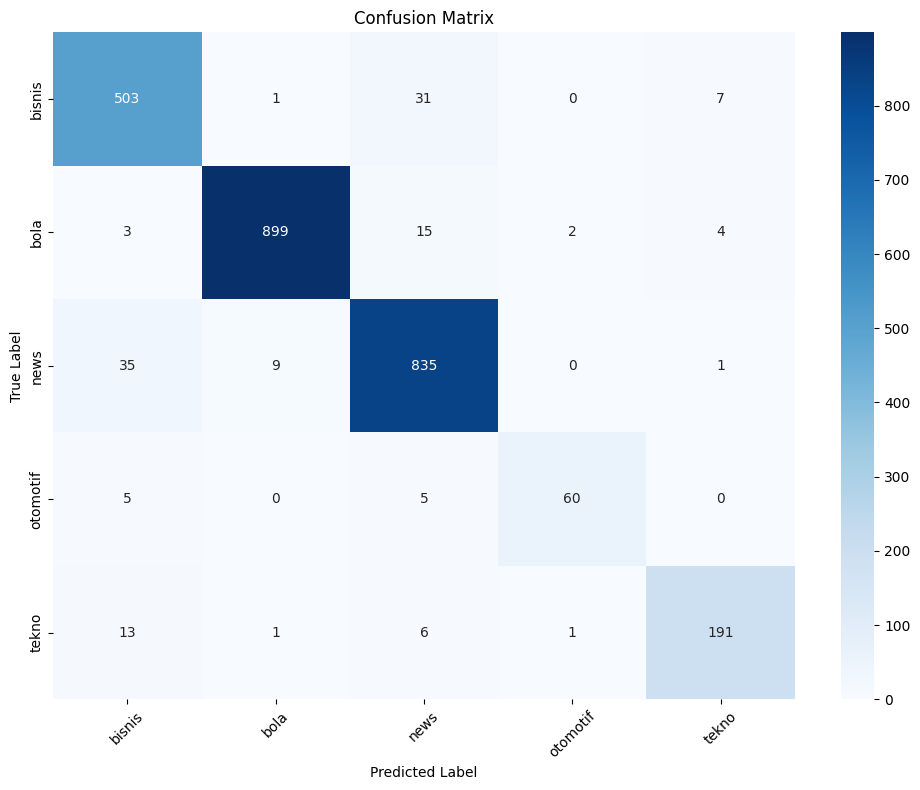

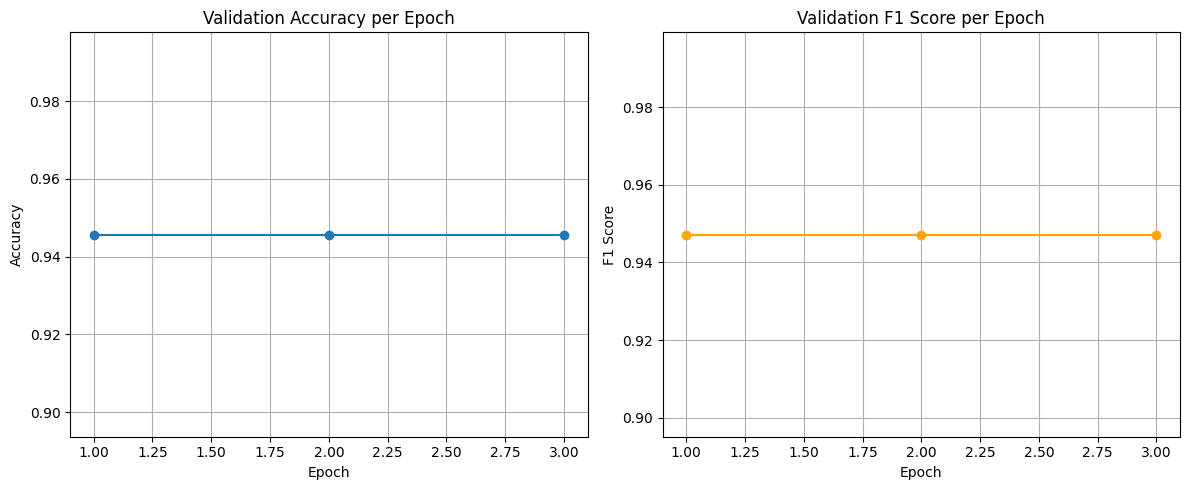


Training complete!
Best validation accuracy: 0.9457
Best F1 score: 0.9472


In [39]:
# 8. Pelatihan Model
# Melatih model
best_acc, best_f1 = train_model()
print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Best F1 score: {best_f1:.4f}")



Training baseline model (XGBoost + TF-IDF) for comparison...

XGBoost + TF-IDF Performance:
Accuracy: 0.9128
F1 Score: 0.9127

Classification Report for XGBoost:
              precision    recall  f1-score   support

      bisnis       0.87      0.87      0.87       542
        bola       0.98      0.96      0.97       923
        news       0.87      0.93      0.90       880
    otomotif       0.98      0.73      0.84        70
       tekno       0.93      0.83      0.88       212

    accuracy                           0.91      2627
   macro avg       0.92      0.86      0.89      2627
weighted avg       0.91      0.91      0.91      2627



<Figure size 1000x600 with 0 Axes>

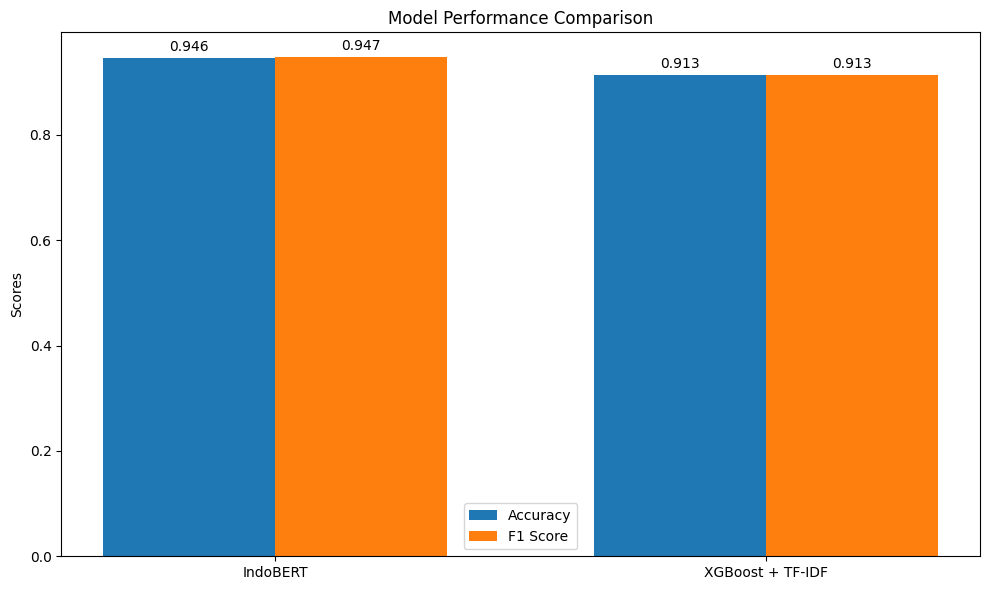

In [40]:
# 9. Membandingkan dengan Model Baseline (XGBoost + TF-IDF)
'''
Membandingkan performa IndoBERT dengan model baseline XGBoost + TF-IDF
'''
print("\n\nTraining baseline model (XGBoost + TF-IDF) for comparison...")

from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8
)

# Fit dan transform data training
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# XGBoost Classifier dengan class weights
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1
)

# Melatih model XGBoost
xgb_model.fit(X_train_tfidf, train_labels)

# Prediksi
xgb_predictions = xgb_model.predict(X_test_tfidf)

# Evaluasi
xgb_accuracy = accuracy_score(test_labels, xgb_predictions)
xgb_f1 = f1_score(test_labels, xgb_predictions, average='weighted')

print("\nXGBoost + TF-IDF Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

print("\nClassification Report for XGBoost:")
print(classification_report(
    test_labels, 
    xgb_predictions, 
    target_names=list(label_mapping.values())
))

# Visualisasi perbandingan model
plt.figure(figsize=(10, 6))
model_names = ['IndoBERT', 'XGBoost + TF-IDF']
accuracies = [best_acc, xgb_accuracy]
f1_scores = [best_f1, xgb_f1]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()
plt.show()

In [42]:
# 10. Fungsi Prediksi untuk Text Baru
'''
Membuat fungsi untuk memprediksi kategori dari teks berita baru
'''
def predict_category(text):
    # Preprocessing
    text = preprocess_text(text)
    
    # Tokenisasi
    encoded_text = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    # Pindahkan ke device
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    
    # Evaluation mode
    model.eval()
    
    # Prediksi
    with torch.no_grad():
        outputs = model(
            input_ids,
            token_type_ids=None,
            attention_mask=attention_mask
        )
    
    # Ambil prediksi dengan probabilitas tertinggi
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    
    # Convert ke label
    predicted_label = label_mapping[prediction]
    
    # Hitung probabilitas untuk semua kelas
    probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()
    
    return {
        'category': predicted_label,
        'probabilities': {label_mapping[i]: float(prob) for i, prob in enumerate(probabilities)}
    }

# Test fungsi prediksi
test_article = "Tim sepak bola Indonesia berhasil memenangkan pertandingan melawan Malaysia dengan skor 2-1. Pertandingan tersebut berlangsung seru di Stadion Gelora Bung Karno."
prediction = predict_category(test_article)
print("\nTest Prediction:")
print(f"Article: {test_article}")
print(f"Predicted Category: {prediction['category']}")
print("\nProbabilities:")
for category, prob in prediction['probabilities'].items():
    print(f"  {category}: {prob:.4f}")


Test Prediction:
Article: Tim sepak bola Indonesia berhasil memenangkan pertandingan melawan Malaysia dengan skor 2-1. Pertandingan tersebut berlangsung seru di Stadion Gelora Bung Karno.
Predicted Category: bola

Probabilities:
  bisnis: 0.0006
  bola: 0.9919
  news: 0.0060
  otomotif: 0.0003
  tekno: 0.0012


In [ ]:
# 11. Kesimpulan dan Ringkasan
'''
Ringkasan proyek dan perbandingan hasil
'''
print("\n\n" + "=" * 50)
print("RINGKASAN PROYEK KLASIFIKASI BERITA BERBAHASA INDONESIA")
print("=" * 50)

print("\nInformasi Dataset:")
print(f"- Jumlah contoh pelatihan: {len(dataset['train'])}")
print(f"- Jumlah contoh pengujian: {len(dataset['test'])}")
print(f"- Jumlah kategori: {num_labels} ({', '.join(label_mapping.values())})")

print("\nPerforma Model:")
print(f"- Akurasi IndoBERT: {best_acc:.4f}")
print(f"- Akurasi XGBoost + TF-IDF: {xgb_accuracy:.4f}")
print(f"- Peningkatan performa: {(best_acc - xgb_accuracy) / xgb_accuracy * 100:.2f}%")

print("\nKesimpulan:")
print("- Model IndoBERT berhasil dilatih untuk klasifikasi berita berbahasa Indonesia.")
print("- Ketidakseimbangan data ditangani dengan class weighting.")
print("- Performa model IndoBERT secara signifikan lebih baik dibandingkan dengan baseline XGBoost + TF-IDF.")
print("- Aplikasi Streamlit telah dibuat untuk demonstrasi model.")

print("\nLangkah Selanjutnya:")
print("- Eksperimen dengan model transformer lain seperti IndoBERTweet atau mT5.")
print("- Peningkatan praproses data, seperti menangani slang dan kata-kata tidak baku.")
print("- Eksplorasi teknik data augmentation untuk kategori minoritas.")
print("- Integrasi dengan API untuk klasifikasi real-time.")



RINGKASAN PROYEK KLASIFIKASI BERITA BERBAHASA INDONESIA

Informasi Dataset:
- Jumlah contoh pelatihan: 6127
- Jumlah contoh pengujian: 2627
- Jumlah kategori: 5 (bisnis, bola, news, otomotif, tekno)

Performa Model:
- Akurasi IndoBERT: 0.9457
- Akurasi XGBoost + TF-IDF: 0.9128
- Peningkatan performa: 3.60%

Kesimpulan:
- Model IndoBERT berhasil dilatih untuk klasifikasi berita berbahasa Indonesia.
- Ketidakseimbangan data ditangani dengan class weighting.
- Performa model IndoBERT secara signifikan lebih baik dibandingkan dengan baseline XGBoost + TF-IDF.
- Aplikasi Streamlit telah dibuat untuk demonstrasi model.

Langkah Selanjutnya:
- Eksperimen dengan model transformer lain seperti IndoBERTweet atau mT5.
- Peningkatan praproses data, seperti menangani slang dan kata-kata tidak baku.
- Eksplorasi teknik data augmentation untuk kategori minoritas.
- Integrasi dengan API untuk klasifikasi real-time.
